In [4]:
#generating fake data fro testing and prototyping
from faker import Faker

In [5]:
import random
import pandas as pd
# For randomization and manupulation

In [8]:
from faker import Faker
import random
import pandas as pd
from datetime import datetime, timedelta

# Initialize Faker
fake = Faker()
data = []

# List of Kenyan cities and towns
kenyan_cities = [
    "Nairobi", "Mombasa", "Kisumu", "Nakuru", "Eldoret", "Thika", 
    "Malindi", "Machakos", "Naivasha", "Nyeri", "Kericho", "Kakamega", 
    "Kitale", "Embu", "Isiolo", "Garissa", "Meru", "Kajiado", 
    "Nanyuki", "Lamu", "Voi", "Homa Bay", "Bungoma", "Kilifi"
]

# Helper function to generate realistic timestamps
def generate_realistic_timestamp():
    # Randomly select a date within the year
    base_date = fake.date_this_year()
    
    # Simulate peak and off-peak transaction times
    if random.random() < 0.7:  # 70% chance for peak hours
        hour = random.randint(8, 20)  # Business hours
    else:  # 30% chance for off-peak hours
        hour = random.choice([6, 7, 21, 22, 23])  # Early morning or late night
    
    # Randomize minute and second
    minute = random.randint(0, 59)
    second = random.randint(0, 59)
    
    # Combine into a datetime
    timestamp = datetime(
        base_date.year, base_date.month, base_date.day, hour, minute, second
    )
    
    return timestamp

# Generate 10,000 synthetic transactions
for _ in range(10000):
    transaction = {
        "Transaction_ID": fake.uuid4(),
        "Sender_ID": f"S{random.randint(1, 5000)}",
        "Receiver_ID": f"R{random.randint(1, 5000)}",
        "Amount": random.randint(10, 100000),
        "Timestamp": generate_realistic_timestamp(),
        "Device_Type": random.choice(["USSD", "Mobile_App", "Web_Portal"]),
        "Location": random.choice(kenyan_cities),
        "Network_ID": random.choice(["Safaricom", "Airtel", "Telkom"]),
        "Fraud_Label": random.choice([0, 1]),
    }
    data.append(transaction)

# Create a DataFrame and save as CSV
df = pd.DataFrame(data)
df.to_csv("synthetic_mobile_money_transactions.csv", index=False)
print("Dataset saved as synthetic_mobile_money_transactions.csv")


Dataset saved as synthetic_mobile_money_transactions.csv


# Data Loading and Inspecting

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import joblib
from flask import Flask, request, jsonify
import warnings
warnings.filterwarnings("ignore")


In [9]:
import pandas as pd

#loading the dataset
df = pd.read_csv("synthetic_mobile_money_transactions.csv")


In [10]:
df.head()

,Transaction_ID,Sender_ID,Receiver_ID,Amount,Timestamp,Device_Type,Location,Network_ID,Fraud_Label
0,bbf519ea-aa7d-4dd9-9793-eff262757890,S264,R2231,28146,2024-08-20 13:48:51,Mobile_App,Garissa,Telkom,1
1,0a0c504d-a802-4d91-92e7-e2aacd7d6c1a,S4106,R435,95556,2024-10-02 11:02:10,USSD,Kajiado,Safaricom,1
2,50613ad4-51e3-4e94-b364-7f2a2d5eb3a8,S4933,R4564,53812,2024-08-25 07:02:11,Web_Portal,Kericho,Airtel,0
3,476d4b21-0ed5-4460-a4bf-30fcfb610e3c,S1736,R4926,23367,2024-11-16 17:45:08,Mobile_App,Kakamega,Safaricom,0
4,2c53ddb3-d541-49d2-bd37-449436e08b36,S3403,R4746,80116,2024-03-11 06:30:41,USSD,Mombasa,Airtel,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Transaction_ID  10000 non-null  object
 1   Sender_ID       10000 non-null  object
 2   Receiver_ID     10000 non-null  object
 3   Amount          10000 non-null  int64 
 4   Timestamp       10000 non-null  object
 5   Device_Type     10000 non-null  object
 6   Location        10000 non-null  object
 7   Network_ID      10000 non-null  object
 8   Fraud_Label     10000 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 703.3+ KB


In [12]:
df.describe()

,Amount,Fraud_Label
count,10000.000000,10000.000000
mean,50254.601600,0.513700
std,28764.006217,0.499837
min,11.000000,0.000000
25%,25539.500000,0.000000
50%,50926.000000,1.000000
75%,74939.750000,1.000000
max,99991.000000,1.000000


# DATA CLEANING

In [14]:
# Display the unique timestamp column
print(df['Timestamp'].head())

0    2024-08-20 13:48:51
1    2024-10-02 11:02:10
2    2024-08-25 07:02:11
3    2024-11-16 17:45:08
4    2024-03-11 06:30:41
Name: Timestamp, dtype: object


In [17]:
print(df.isnull().sum())

Transaction_ID    0
Sender_ID         0
Receiver_ID       0
Amount            0
Timestamp         0
Device_Type       0
Location          0
Network_ID        0
Fraud_Label       0
dtype: int64


In [18]:
df = df.drop_duplicates()

In [22]:
# Standardize continuous variables
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])


In [24]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['Device_Type', 'Location', 'Network_ID']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Save LabelEncoders for future use
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

# Outlier Detection

In [25]:
# Use the IQR method to detect and remove outliers
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
df = df[(df['Amount'] >= (Q1 - 1.5 * IQR)) & (df['Amount'] <= (Q3 + 1.5 * IQR))]


# Exploratory Data Analysis (EDA)

In [28]:
print(df.dtypes)


Transaction_ID     object
Sender_ID          object
Receiver_ID        object
Amount            float64
Timestamp          object
Device_Type         int64
Location            int64
Network_ID          int64
Fraud_Label         int64
dtype: object


In [29]:
numeric_df = df.select_dtypes(include=['number'])


1. CORRELATION HEATMAP

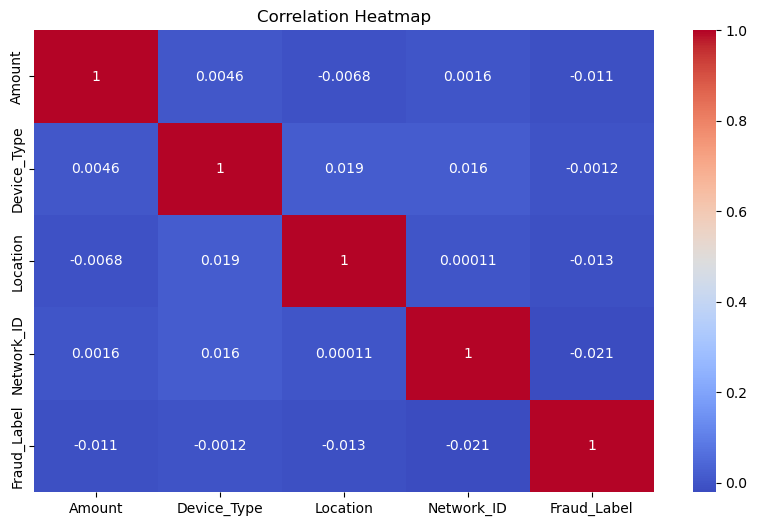

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


2. DISTRIBUTION OF FRAUD VS NON-FRAUD

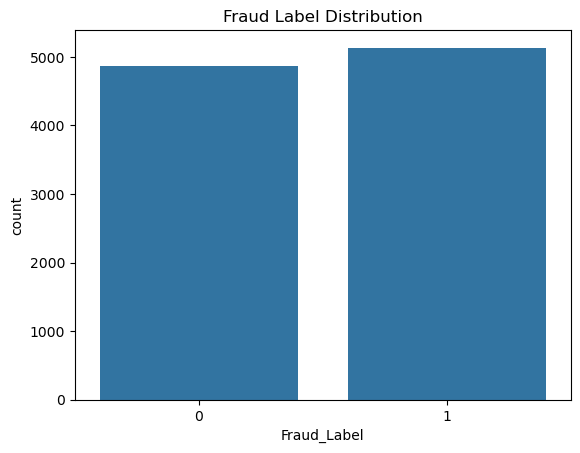

In [31]:
# Distribution of Fraud vs Non-Fraud
sns.countplot(data=df, x="Fraud_Label")
plt.title("Fraud Label Distribution")
plt.show()

3. VISUALIZE AMOUNT DISTRIBUTION

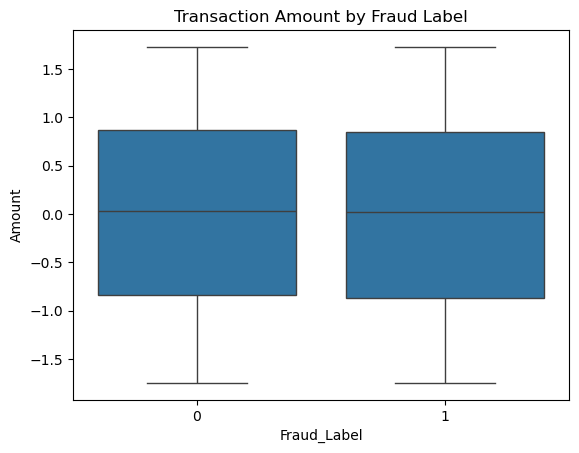

In [32]:
# Visualize Amount distribution
sns.boxplot(data=df, x="Fraud_Label", y="Amount")
plt.title("Transaction Amount by Fraud Label")
plt.show()

4. PAIRPLOT FOR NUMERICAL FEATURES

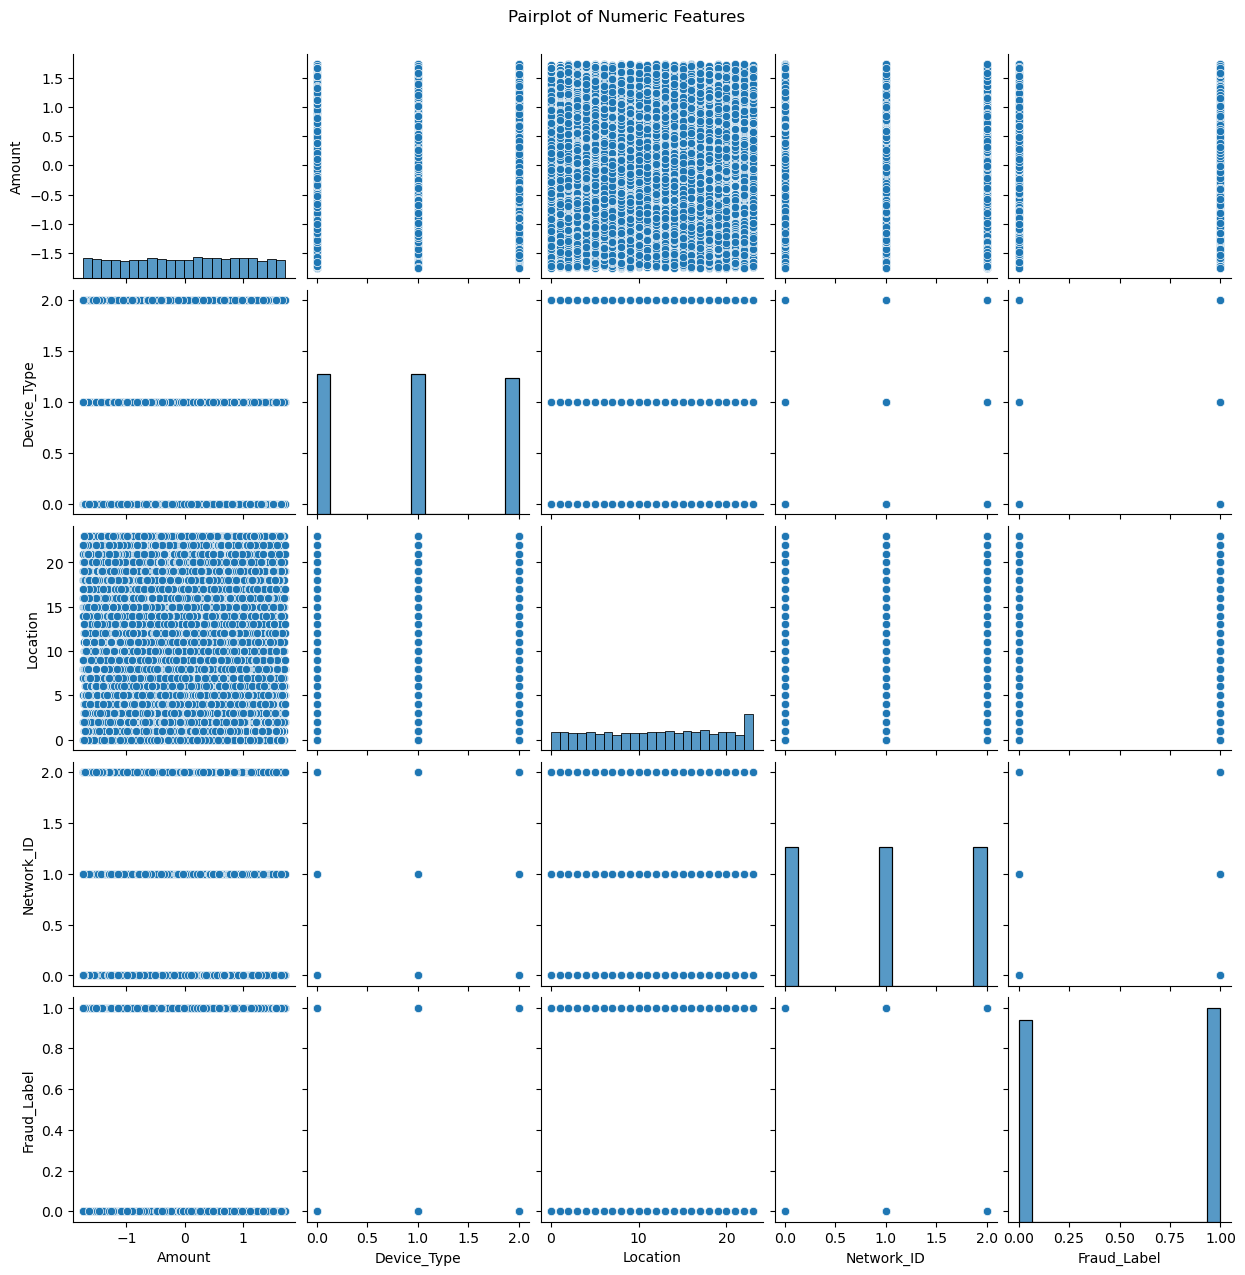

In [33]:
sns.pairplot(df.select_dtypes(include=['number']))
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()


4. Correlation Heatmap with Annotations (using a mask):
- This helpS visualize the correlation matrix more clearly by masking the upper triangle, which often contains redundant information.

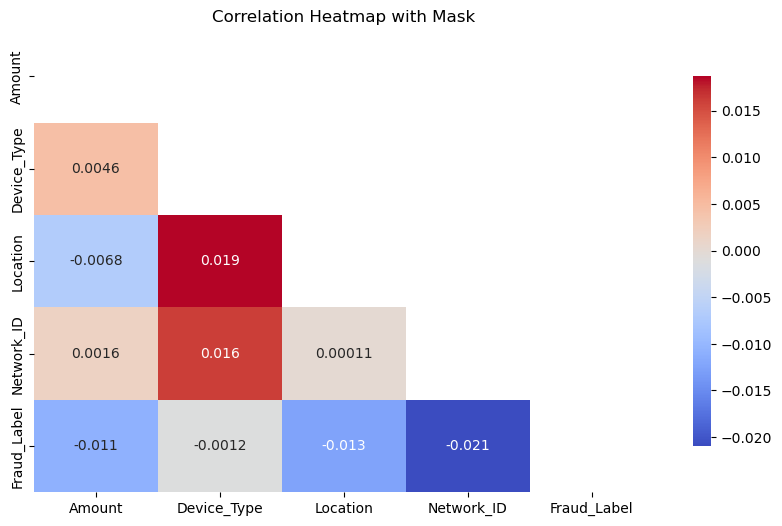

In [35]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
plt.figure(figsize=(10, 6))
corr = numeric_df.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, cbar_kws={'shrink': 0.8})
plt.title("Correlation Heatmap with Mask")
plt.show()


5. Distribution of Amount (Histogram)
- A histogram  helpS visualize the distribution of transaction amounts across all rows, and you can split by fraud or non-fraud labels.



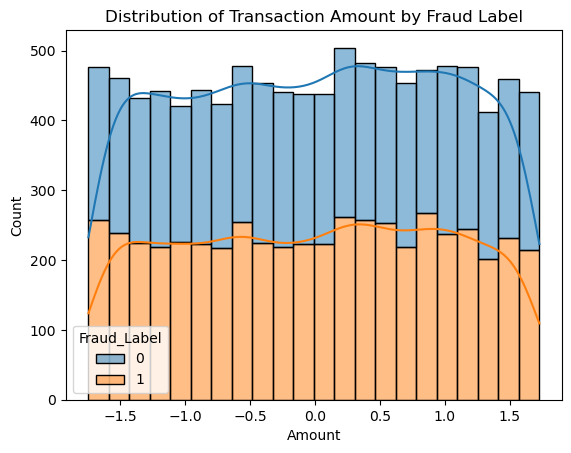

In [36]:
sns.histplot(df, x="Amount", kde=True, hue="Fraud_Label", multiple="stack")
plt.title("Distribution of Transaction Amount by Fraud Label")
plt.show()


6. Bar Plot for Device_Type vs Fraud_Label:
- This show how fraud labels are distributed across different device types.

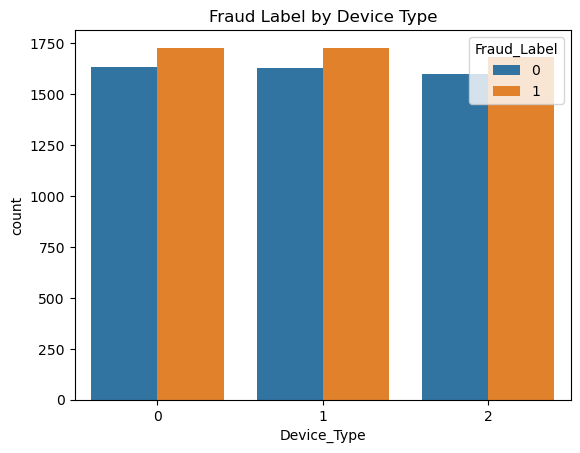

In [37]:
sns.countplot(data=df, x="Device_Type", hue="Fraud_Label")
plt.title("Fraud Label by Device Type")
plt.show()


7. Boxplot for Location vs Fraud_Label:
- A boxplot help compare the distribution of the Location feature by Fraud_Label

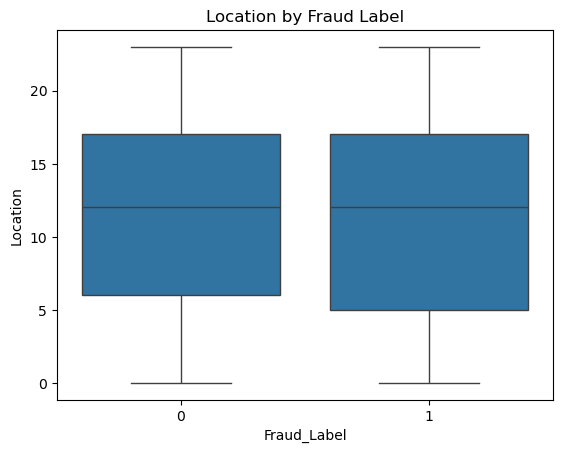

In [39]:
sns.boxplot(data=df, x="Fraud_Label", y="Location")
plt.title("Location by Fraud Label")
plt.show()


8. Time-based Analysis (if Timestamp is in DateTime Format):

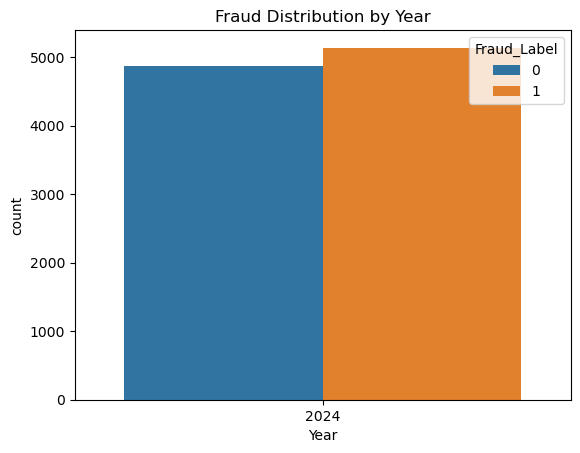

In [40]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Convert to DateTime if needed
df['Year'] = df['Timestamp'].dt.year  # Extract year for grouping
sns.countplot(data=df, x="Year", hue="Fraud_Label")
plt.title("Fraud Distribution by Year")
plt.show()


9. Count of Fraud by Network_ID:


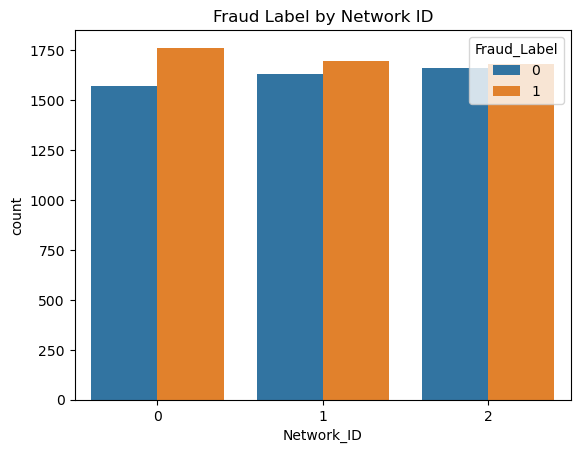

In [41]:
sns.countplot(data=df, x="Network_ID", hue="Fraud_Label")
plt.title("Fraud Label by Network ID")
plt.show()


10. FacetGrid for Amount by Device_Type and Fraud_Label:
- FacetGrid for Amount by Device_Type and Fraud_Label:

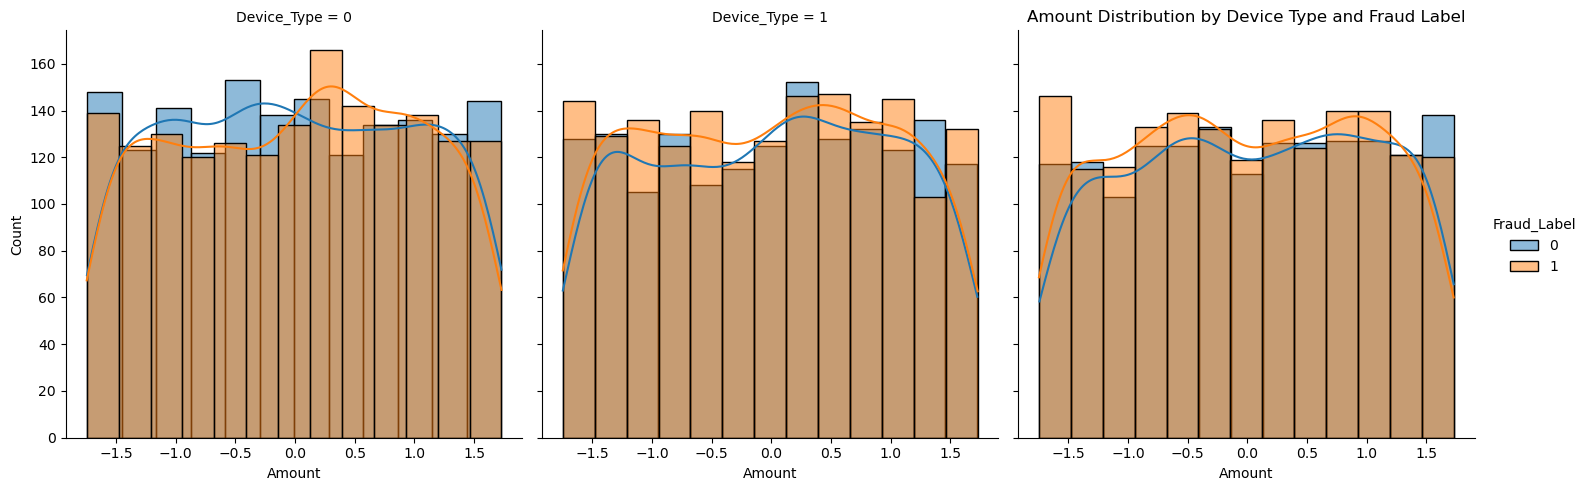

In [42]:
g = sns.FacetGrid(df, col="Device_Type", hue="Fraud_Label", height=5)
g.map(sns.histplot, "Amount", kde=True)
g.add_legend()
plt.title("Amount Distribution by Device Type and Fraud Label")
plt.show()


# Feature Engineering

In [43]:
# Create new feature: Transaction frequency by sender
transaction_frequency = df.groupby("Sender_ID")['Transaction_ID'].count()
df['Transaction_Frequency'] = df['Sender_ID'].map(transaction_frequency)

In [46]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Prepare the feature set and target variable
X = df.drop(["Fraud_Label", "Transaction_ID"], axis=1)
y = df["Fraud_Label"]

# Convert categorical columns to numeric using LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = X.select_dtypes(include=['object']).columns

# Apply label encoding to each categorical column
for col in categorical_columns:
    X[col] = label_encoder.fit_transform(X[col])

# Convert the 'Timestamp' column to a numeric format (e.g., Unix timestamp)
X['Timestamp'] = pd.to_datetime(X['Timestamp']).astype(int) / 10**9  # Convert to Unix timestamp in seconds

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Initialize RFE with the logistic regression model and select top 5 features
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(X, y)

# Print the selected features
print("Selected Features: ", list(X.columns[fit.support_]))


Selected Features:  ['Amount', 'Device_Type', 'Location', 'Network_ID', 'Transaction_Frequency']


# Model Development

In [47]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


Accuracy: 0.5123333333333333
Precision: 0.5246523388116309
Recall: 0.5386112913692408
F1-Score: 0.5315401857188601
AUC-ROC: 0.5058548186445074


# Model Tuning

In [50]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters: ", grid_search.best_params_)

# Use the best model
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   3.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   3.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   4.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   4.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=300; total time=   5.0s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, 

# Model Deployment

In [51]:
joblib.dump(best_model, 'fraud_detection_model.pkl')


['fraud_detection_model.pkl']